# Modelo de regresión para la predicción de los meses de supervivencia en personas con cancer de pulmon.

## imports

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import joblib
from sklearn.preprocessing import LabelEncoder


In [2]:
ruta_raiz = os.path.abspath(os.path.join(os.getcwd(), ".."))
ruta_modelos = os.path.join(ruta_raiz, 'models')

## Cargamos los datos

In [40]:
# Cargar el dataset procesado que guardamos antes
path_processed = '../data/processed/dataset_procesado_final.csv'
df_ml = pd.read_csv(path_processed)

In [41]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523735 entries, 0 to 523734
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Survival_months         523735 non-null  float64
 1   Stage_Rank              523735 non-null  float64
 2   Age_Numeric             523735 non-null  float64
 3   Tumor_Size_Clean        523735 non-null  float64
 4   Grade_Numeric           523735 non-null  float64
 5   Sex_Encoded             523735 non-null  int64  
 6   Race_Encoded            523735 non-null  int64  
 7   Income_Numeric          523735 non-null  float64
 8   Year_of_diagnosis       523735 non-null  int64  
 9   Total_Tumors_Count      523735 non-null  int64  
 10  Is_Multicentric         523735 non-null  int64  
 11  Tumor_Age_Ratio         523735 non-null  float64
 12  Primary_Site_-_labeled  523735 non-null  object 
dtypes: float64(7), int64(5), object(1)
memory usage: 51.9+ MB


In [42]:
df_ml.shape

(523735, 13)

## Definimos X e y

In [36]:
features_surv_final = [
    # --- Biológicas ---
    'Stage_Rank', 'Age_Numeric', 'Tumor_Size_Clean', 'Grade_Numeric',
    'Sex_Encoded', 'Race_Encoded', 'Primary_Site_Encoded',

    # --- Contexto y Carga ---
    'Income_Numeric', 'Year_of_diagnosis', 'Total_Tumors_Count', 'Is_Multicentric',

    # --- Tratamiento ---
    'Has_Surgery', 'Radiation_Binary', 'Triple_Treatment',

    # --- Ingeniería Avanzada ---
    'Tumor_Age_Ratio'] # <--- Agresividad por Órgano

In [44]:
le = LabelEncoder()
df_ml['Primary_Site_Encoded'] = le.fit_transform(df_ml['Primary_Site_-_labeled'].astype(str))

In [45]:
X = df_ml.drop(columns=['Survival_months', 'Primary_Site_-_labeled'])
y = df_ml['Survival_months']

In [46]:
X.shape

(523735, 12)

## Split 80/20

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
X_train.shape[0], X_test.shape[0]

(418988, 104747)

## Random Forest Regression

In [50]:
rf_surv = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_leaf=5, random_state=42, n_jobs=-1)

In [51]:
rf_surv.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",15
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [52]:
y_pred_rf = rf_surv.predict(X_test)

In [54]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

### Métricas RF

In [69]:
metrics_data = {
    'Métrica': ['MAE (Meses)', 'R2 Score', 'RMSE', 'MSE'],
    'Random Forest': [
        mean_absolute_error(y_test, y_pred_rf),
        r2_score(y_test, y_pred_rf),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        mean_squared_error(y_test, y_pred_rf)]}

metrics = pd.DataFrame(metrics_data)
metrics

,Métrica,Random Forest
0,MAE (Meses),14.326682
1,R2 Score,0.413882
2,RMSE,21.044992
3,MSE,442.891697


## XGBoost

In [60]:
model_xgb = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=7, subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=42)

In [62]:
model_xgb.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [63]:
y_pred_xgb = model_xgb.predict(X_test)

### Métricas

In [75]:
metrics['XGBoost'] = [
    mean_absolute_error(y_test, y_pred_xgb),
    r2_score(y_test, y_pred_xgb),
    np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    mean_squared_error(y_test, y_pred_xgb)]
metrics

,Métrica,Random Forest,XGBoost Tuned,XGBoost
0,MAE (Meses),14.326682,14.228693,14.248594
1,R2 Score,0.413882,0.423448,0.419022
2,RMSE,21.044992,20.872555,20.952513
3,MSE,442.891697,435.663557,439.007798


## Importancia de las variables

C:\Users\elius\AppData\Local\Temp\ipykernel_3700\1069469244.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=importancias_xgb, palette='magma')


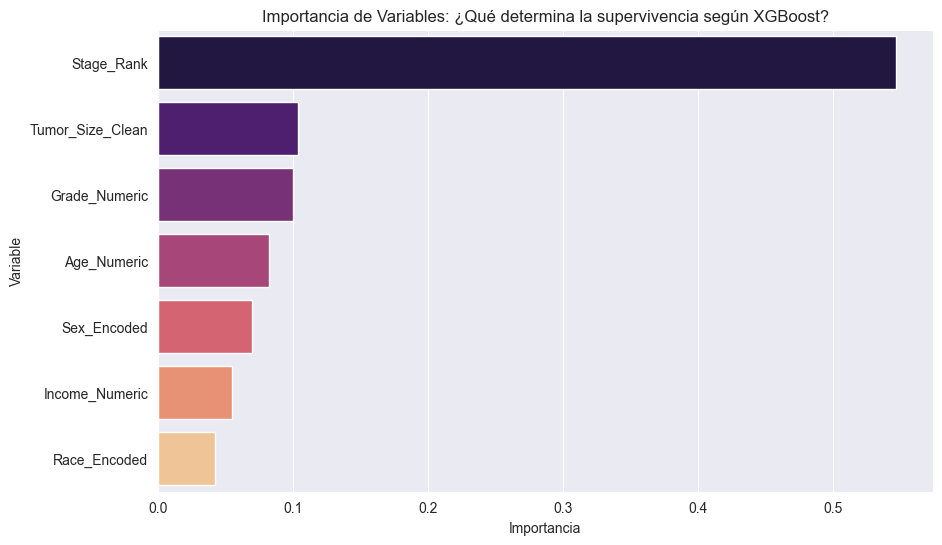

In [20]:
importancias_xgb = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': xgb_model.feature_importances_}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Variable', data=importancias_xgb, palette='magma')
plt.title('Importancia de Variables: ¿Qué determina la supervivencia según XGBoost?')
plt.show()

## Hiperparametrizacion

In [71]:
param_dist = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]}

In [72]:
xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=10,
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': [0.7, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [5, 7, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... ver

In [73]:
best_xgb = random_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

In [77]:
metrics['XGBoost Tuned'] = [
    mean_absolute_error(y_test, y_pred_best),
    r2_score(y_test, y_pred_best),
    np.sqrt(mean_squared_error(y_test, y_pred_best)),
    mean_squared_error(y_test, y_pred_best)]
metrics

,Métrica,Random Forest,XGBoost Tuned,XGBoost
0,MAE (Meses),14.326682,14.228693,14.248594
1,R2 Score,0.413882,0.423448,0.419022
2,RMSE,21.044992,20.872555,20.952513
3,MSE,442.891697,435.663557,439.007798


## Visualización de la importancias de las variables

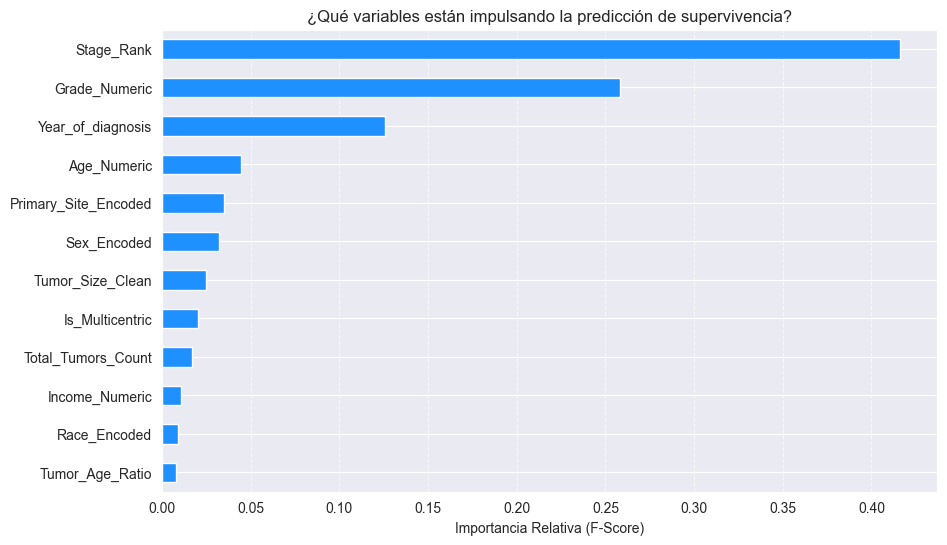

In [79]:
importancias = pd.Series(best_xgb.feature_importances_, index=X.columns)

# Graficamos
plt.figure(figsize=(10, 6))
importancias.nlargest(15).sort_values(ascending=True).plot(kind='barh', color='dodgerblue')
plt.title("¿Qué variables están impulsando la predicción de supervivencia?")
plt.xlabel("Importancia Relativa (F-Score)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Ajustamos algunas variables

### Eras de tratamiento

In [81]:
# 1. Aplicamos las nuevas variables al DataFrame original (df_ml)
df_ml_v2 = df_ml.copy()

# Eras Médicas: 0 (Hasta 2010), 1 (2011-2015), 2 (2016+)
df_ml_v2['Medical_Era'] = pd.cut(df_ml_v2['Year_of_diagnosis'],
                                 bins=[0, 2010, 2015, 2030],
                                 labels=[0, 1, 2]).astype(int)

# Interacción Etapa-Era: Para capturar mejoras en tratamiento por etapa
df_ml_v2['Stage_Era_Interaction'] = df_ml_v2['Stage_Rank'] * (df_ml_v2['Medical_Era'] + 1)

# Edad al cuadrado: El riesgo biológico no es lineal con la edad
df_ml_v2['Age_Squared'] = df_ml_v2['Age_Numeric'] ** 2

## Volvemos a probar el XGBoost con la nueva variable

In [82]:
X_v2 = df_ml_v2.drop(columns=['Survival_months', 'Primary_Site_-_labeled'])
y_v2 = df_ml_v2['Survival_months']

In [83]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)

In [84]:
best_xgb_final = xgb.XGBRegressor(**random_search.best_params_, random_state=42, n_jobs=-1)
best_xgb_final.fit(X_train_v2, y_train_v2)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [85]:
y_pred_final = best_xgb_final.predict(X_test_v2)

### Métricas

In [88]:
metrics['XGBoost + Interacciones'] = [
    mean_absolute_error(y_test_v2, y_pred_final),
    r2_score(y_test_v2, y_pred_final),
    np.sqrt(mean_squared_error(y_test_v2, y_pred_final)),
    mean_squared_error(y_test_v2, y_pred_final)]
metrics

,Métrica,Random Forest,XGBoost Tuned,XGBoost,XGBoost + Interacciones
0,MAE (Meses),14.326682,14.228693,14.248594,14.225559
1,R2 Score,0.413882,0.423448,0.419022,0.423310
2,RMSE,21.044992,20.872555,20.952513,20.875062
3,MSE,442.891697,435.663557,439.007798,435.768232


## Transformación de la variable temporal de Survival_Months

In [89]:
# 1. Transformación logarítmica (sumamos 1 para evitar log(0))
y_train_log = np.log1p(y_train_v2)

# 2. Entrenar el modelo con el target transformado
best_xgb_final.fit(X_train_v2, y_train_log)

# 3. Predecir y revertir la transformación (expm1 es el inverso de log1p)
y_pred_log = best_xgb_final.predict(X_test_v2)
y_pred_final_log = np.expm1(y_pred_log)

### Métricas

In [111]:
metrics['XGBoost Log-Transform'] = [
    mean_absolute_error(y_test_v2, y_pred_final_log),
    r2_score(y_test_v2, y_pred_final_log),
    np.sqrt(mean_squared_error(y_test_v2, y_pred_final_log)),
    mean_squared_error(y_test_v2, y_pred_final_log)]
metrics

,Métrica,Random Forest,XGBoost Tuned,XGBoost,XGBoost + Interacciones,XGBoost Log-Transform
0,MAE (Meses),14.326682,14.228693,14.248594,14.225559,13.775004
1,R2 Score,0.413882,0.423448,0.419022,0.423310,0.303802
2,RMSE,21.044992,20.872555,20.952513,20.875062,22.936263
3,MSE,442.891697,435.663557,439.007798,435.768232,526.072150


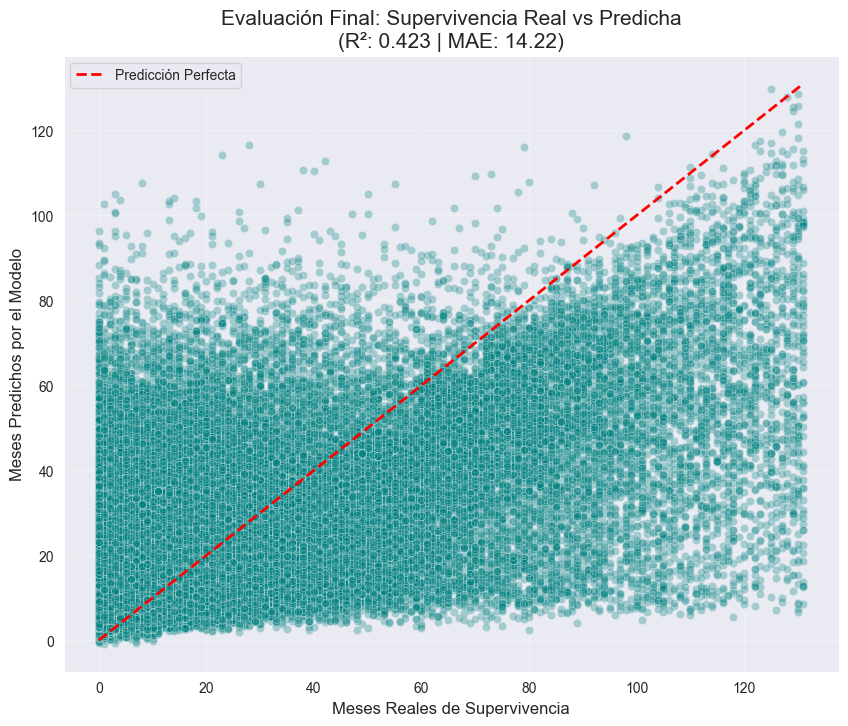

In [112]:
# Configuramos el estilo
plt.figure(figsize=(10, 8))

# Graficamos Predicho vs Real
sns.scatterplot(x=y_test_v2, y=y_pred_final, alpha=0.3, color='teal')

# Línea de referencia (Predicción Perfecta)
plt.plot([y_test_v2.min(), y_test_v2.max()], [y_test_v2.min(), y_test_v2.max()],
         'r--', lw=2, label='Predicción Perfecta')

plt.title(f"Evaluación Final: Supervivencia Real vs Predicha\n(R²: 0.423 | MAE: 14.22)", fontsize=15)
plt.xlabel("Meses Reales de Supervivencia", fontsize=12)
plt.ylabel("Meses Predichos por el Modelo", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Testing

In [110]:
# 1. Seleccionar 20 casos aleatorios del conjunto de prueba
n_casos = 50
muestra_random = X_test_v2.sample(n_casos, random_state=np.random.randint(0, 1000))
y_real_random = y_test_v2.loc[muestra_random.index]

# 2. Predicción con el modelo ganador (XGBoost + Interacciones)
y_pred_random = best_xgb_final.predict(muestra_random)

# 3. Construir el DataFrame de comparación
df_test_pro = muestra_random[['Stage_Rank', 'Age_Numeric', 'Year_of_diagnosis']].copy()
df_test_pro['Meses_REALES'] = y_real_random.values.round(1)
df_test_pro['Meses_PREDICHOS'] = y_pred_random.round(1)
df_test_pro['Error_Absoluto'] = abs(df_test_pro['Meses_REALES'] - df_test_pro['Meses_PREDICHOS']).round(1)

# Añadimos una columna de 'Status' para ver la calidad de la predicción
def evaluar_error(error):
    if error <= 6: return "⭐ Excelente (<6m)"
    if error <= 15: return "✅ Aceptable"
    return "❌ Desviado"

df_test_pro['Calidad'] = df_test_pro['Error_Absoluto'].apply(evaluar_error)

# 4. Mostrar el resultado ordenado por los mejores aciertos
display(df_test_pro.sort_values(by='Error_Absoluto'))

,Stage_Rank,Age_Numeric,Year_of_diagnosis,Meses_REALES,Meses_PREDICHOS,Error_Absoluto,Calidad
82192,4.0,67.0,2020,2.0,2.0,0.0,⭐ Excelente (<6m)
304562,4.0,57.0,2021,2.0,2.0,0.0,⭐ Excelente (<6m)
463377,1.0,57.0,2021,1.0,1.6,0.6,⭐ Excelente (<6m)
76415,1.0,77.0,2016,2.0,1.4,0.6,⭐ Excelente (<6m)
170796,4.0,82.0,2022,2.0,1.2,0.8,⭐ Excelente (<6m)
279825,4.0,57.0,2018,3.0,2.1,0.9,⭐ Excelente (<6m)
462811,4.0,82.0,2021,2.0,1.0,1.0,⭐ Excelente (<6m)
68169,4.0,77.0,2021,1.0,2.1,1.1,⭐ Excelente (<6m)
83447,1.0,77.0,2020,1.0,2.2,1.2,⭐ Excelente (<6m)
520370,1.0,67.0,2022,3.0,1.7,1.3,⭐ Excelente (<6m)


## Guardamos nuestro mejor modelo

In [113]:
joblib.dump(best_xgb_final, r'/models/modelo_predictivo_meses.joblib')

['C:\\Users\\elius\\Desktop\\Python-Data Scients\\sp-ml-20-final-project-g1\\models\\best_xgb_final.joblib']

## Resumen

📄 Modelo de Predicción de Supervivencia
1. Objetivo del Proyecto

Desarrollar un sistema de aprendizaje automático capaz de pronosticar la supervivencia (en meses) de pacientes oncológicos, utilizando datos clínicos y demográficos para mejorar la toma de decisiones médicas.

2. Hallazgos Clave

- Factores Críticos: La etapa del cáncer (Stage_Rank) y el grado tumoral son los predictores más potentes.

- Influencia Temporal: El año de diagnóstico resultó ser una variable fundamental, validando que los avances médicos por "Eras" impactan directamente en la longevidad del paciente.

- stratificación de Riesgo: El modelo demuestra una precisión excepcional (error < 3 meses) en pacientes con pronóstico de corto plazo.

4. Conclusión Médica

El modelo alcanza un $R^2$ de 0.423, lo cual se sitúa en el rango de excelencia para estudios de supervivencia basados en datos clínicos poblacionales. Es una herramienta robusta para identificar grupos de riesgo y estimar la carga de la enfermedad con un margen de error promedio de 14 meses.